In [1]:
import numpy as np
import pandas as pd
import pylab as plt
import matplotlib
from astropy import units as u
from starkit.fitkit.likelihoods import SpectralChi2Likelihood as Chi2Likelihood, SpectralL1Likelihood
from starkit.gridkit import load_grid
from starkit.fitkit.multinest.base import MultiNest, MultiNestResult
from starkit import assemble_model, operations
from starkit.fitkit import priors
from starkit.base.operations.spectrograph import (Interpolate, Normalize,
                                                  NormalizeParts,InstrumentConvolveGrating)
from starkit.base.operations.stellar import (RotationalBroadening, DopplerShift)
from specutils import read_fits_file,plotlines
import numpy as np
import os,scipy
from specutils import Spectrum1D,rvmeasure
import datetime,glob
# try:
#     import MySQLdb as mdb
# except:
#     import pymysql as mdb
%matplotlib inline
font = {        'size'   : 20}
matplotlib.rc('font', **font)

In [2]:
specdir = '/u/ghezgroup/data/metallicity/nirspec/spectra/'
savedir = '/u/ghezgroup/data/metallicity/nirspec/spectra_fits/'
starname = 'NE_1_001'
file2 = glob.glob(specdir+starname+'_order35_*.dat')
snr = 30.0
starspectrum35 = read_fits_file.read_nirspec_dat(file2,desired_wavelength_units='Angstrom',
                                                 wave_range=[2.178,2.20882])
starspectrum35.uncertainty = (np.zeros(len(starspectrum35.flux.value))+1.0/np.float(snr))*starspectrum35.flux.unit

savefile = os.path.join(savedir,starname+'order35_test_results.h5')
# restore MultiNest savefile

clipping [2.178, 2.20882]


# Fit the star

In [3]:
# load the BOSZ grid. Do this only ONCE!! It takes a long time and lots of memory
g = load_grid('/u/tdo/research/metallicity/grids/phoenix_t2000_6000_w20000_24000_R25000.h5')

[starkit.gridkit.base][INFO   ]  Reading index (base.py:266)
[starkit.gridkit.base][INFO   ]  Discovered columns teff, logg, mh, alpha (base.py:269)
[starkit.gridkit.base][INFO   ]  Reading Fluxes (base.py:272)
[starkit.gridkit.base][INFO   ]  Fluxes shape (15423, 18233) (base.py:275)
[py.warnings         ][WARNING]  /u/rbentley/miniconda3/envs/starkit/lib/python2.7/site-packages/astropy/units/format/generic.py:461: UnitsWarning: 'erg/s/angstrom' contains multiple slashes, which is discouraged by the FITS standard
  core.UnitsWarning)
 (generic.py:461)
[starkit.gridkit.base][INFO   ]  Initializing spec grid (base.py:309)
[starkit.gridkit.base][WARNING]  **** NO WAVELENGTH TYPE SET DEFAULTING TO GRID (vacuum) ****

 (base.py:75)
[starkit.gridkit.base][WARNING]  No format_version in meta data for this grid. Please get an updated grid. This will fail in the future. (base.py:316)


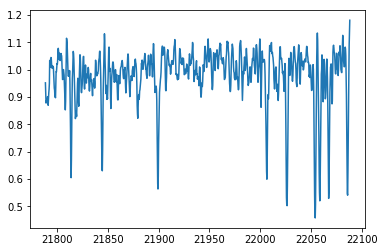

In [4]:
# Galactic center star

# setup the model - these are modules that are used in the fitting
plt.plot(starspectrum35.wavelength.value,starspectrum35.flux.value)
interp1 = Interpolate(starspectrum35)
convolve1 = InstrumentConvolveGrating.from_grid(g,R=24000)
rot1 = RotationalBroadening.from_grid(g,vrot=np.array([10.0]))
norm1 = Normalize(starspectrum35,2)

# concatenate the spectral grid (which will have the stellar parameters) with other 
# model components that you want to fit
model = g | rot1 |DopplerShift(vrad=0.0)| convolve1 | interp1 | norm1

# add likelihood parts
like1 = Chi2Likelihood(starspectrum35)
#like1_l1 = SpectralL1Likelihood(spectrum)

fit_model = model | like1


In [5]:
# look at parameters in the model
model

<CompoundModel4(teff_0=2300.0, logg_0=0.0, mh_0=0.5, alpha_0=0.0, vrot_1=[ 10.], limb_darkening_1=0.6, vrad_2=0.0, R_3=24000.0)>

[py.warnings         ][WARNING]  /u/rbentley/miniconda3/envs/starkit/lib/python2.7/site-packages/starkit/base/operations/spectrograph.py:192: UserWarning: The fit may be poorly conditioned
  warnings.warn(msg)
 (spectrograph.py:192)


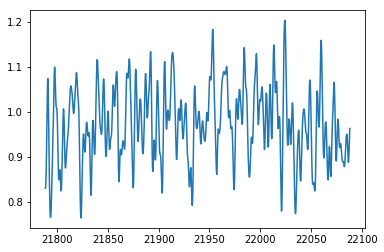

In [6]:
# can evaluate the model using the default parameters
w,f = model()
plt.plot(w,f)

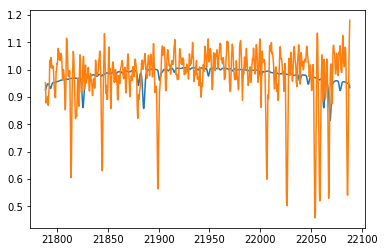

In [7]:
model.teff_0 = 5800
model.logg_0 = 4.4
model.mh_0 = 0
w,f = model()
plt.plot(w,f)
plt.plot(starspectrum35.wavelength,starspectrum35.flux)

In [8]:
print(fit_model())

-7536.33970141


In [9]:
# setup priors for each of the fitting parameters. For fixed parameters use the FixedPrior object

teff_prior = priors.UniformPrior(2500.0,5000.0)
logg_prior = priors.UniformPrior(1.0,4.0)
mh_prior = priors.UniformPrior(-1.0,1.0)
alpha_prior = priors.UniformPrior(-0.25,0.5)
vrot_prior = priors.UniformPrior(0,350.0)
vrad_prior1 = priors.UniformPrior(-1000,1000)
#R_prior1 = priors.UniformPrior(1500,5000)
R_prior1 = priors.FixedPrior(24000)

# make a MultiNest fitting object with the model and the prior 
gc_fitobj = MultiNest(fit_model, [teff_prior, logg_prior, mh_prior, alpha_prior,vrot_prior, vrad_prior1,R_prior1])

# Run the fit using the MultiNest sampler. 
# Will take about 5-10 minutes to run for high resolution Phoenix grid
gc_result = gc_fitobj.run()

# after fitting, save the results to an HDF5 file
gc_result.to_hdf(savefile)

[starkit.fitkit.multinest.base][INFO   ]  Starting fit in /var/folders/ht/yg1qpdss7450bj58zbkchp9c00011x/T/tmp2hIfZ7 with prefix specgrid_multinest (base.py:307)
[starkit.fitkit.multinest.base][INFO   ]  Fit finished - took 588.17 s (base.py:314)
[starkit.fitkit.multinest.base][INFO   ]  Cleaning up - deleting /var/folders/ht/yg1qpdss7450bj58zbkchp9c00011x/T/tmp2hIfZ7 (base.py:322)
Opening /u/ghezgroup/data/metallicity/nirspec/spectra_fits/NE_1_001order35_test_results.h5 in read-only mode


FileModeError: the file is not writable

In [ ]:
# load from the HDF5 file in case the fit was not run
gc_result = MultiNestResult.from_hdf5(savefile)

# summary statistics like the mean and median can be accessed as dictionaries
print(gc_result.median)
print(gc_result.mean)

In [ ]:
# can also compute 1 sigma intervals (or arbitrary)
gc_result.calculate_sigmas(1)

In [ ]:
# can also make corner plots
# be sure to specify parameters if one of them is fixed - if not, corner will crash
gc_result.plot_triangle(parameters=['teff_0','logg_0','mh_0','alpha_0','vrot_1','vrad_2'])

In [ ]:
# set model to median values
for a in gc_result.median.keys():
    setattr(model,a,gc_result.median[a])

w,f = model()

plt.figure(figsize=(15,7))
plt.plot(starspectrum35.wavelength.value/(gc_result.median['vrad_2']/3e5+1.0),starspectrum35.flux)
plt.plot(w/(gc_result.median['vrad_2']/3e5+1.0),f)
plotlines.oplotlines(angstrom=True)
plt.xlabel('Wavelength (Angstrom)')
plt.ylabel('Flux')